In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import random



import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader 
import torch.optim as optim
from torchvision.models.resnet import ResNet, BasicBlock
import scipy.stats as st
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from torchvision import transforms
import torchvision.models as models




In [4]:
# Mounting drive 

from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/MyDrive/Fa21/UCSF/Onboarding/manifest")

Mounted at /content/gdrive


**Task:**

1. Create a basic ResNet architecture to train on breast denseness (we will make this a 2D classification program with 2 classes). There are four breast densities: 1-4, but for this project, set Density 1 and 2 as "not dense". Density 3 and 4 as "dense" to make this a 2-class classification program. 

2. Perform prediction with the algorithm on the testing set and provide your predictions on the test set.

3. Display 10 random mammogram images.

4. Provide confusion matrix and ROC curve. Perform DeLong test and confidence interval around the ROC curve using bootstrapping.

**Adapted from:**

This code is written in reference to: 
1. Pytorch: 

https://zablo.net/blog/post/using-resnet-for-mnist-in-pytorch-tutorial/

https://github.com/bdrad/Onboarding-CV-Tejas-Srivatsav/blob/main/main.py

2. DeLong test:
https://biasedml.com/roc-comparison/

3. Bootstrap AUC: https://github.com/bdrad/Onboarding-Joshua-Wong/blob/main/Onboarding_Joshua_Wong.ipynb 


In [ ]:
# load the numpyz files 

# split to test and train 

# build the ResNet architecture 

# train the ResNet 

# provide predictions on test set 

# confusion matrix and ROC curve 

# perform DeLong teset 

# confidence interval around ROC using bootstrapping 

In [ ]:
# load the labels and split into train and test 
all_labels = pd.read_csv("labels.csv")
test_labels = all_labels[all_labels["Example"].str.contains("Test")]
train_labels = all_labels[all_labels["Example"].str.contains("Train")]

test_labels.to_csv("test_labels.csv", index=False)
train_labels.to_csv("train_labels.csv", index=False)

In [5]:
# load the numpyz files 

# create custom Dataset for the numpyz files 
class Mammogram_Dataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    '''
    annotations_file: (STRING) a csv with the file names and labels of the images in the files. 
    img_dir: (STRING) the directory that contains the images
    ----
    Class inherits from pytorch's Dataset. Acts as custom 
    Pytorch dataset. View the link below for documentation: 
    https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
    '''
      
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform # any transformations or data augmentation on images
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.load(img_path)['arr_0']
        label = self.img_labels.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
          
        image = image.type(torch.float32)
        label = torch.tensor(label, dtype=torch.int64)
        
        return image, label

tensor_transform = transforms.Compose([transforms.ToTensor()])
test_dataset = Mammogram_Dataset(annotations_file="test_labels.csv", img_dir="numpyz_files", transform=tensor_transform)
train_dataset = Mammogram_Dataset(annotations_file="train_labels.csv", img_dir="numpyz_files", transform=tensor_transform)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [45]:
class modifiedResnet(ResNet):
  '''
  Creating a custom class for ResNet that takes in 1 color channel and 
  output 2 classes. 
  '''

  def __init__(self, test_dataloader, train_dataloader):
    '''
    test_dataloader: (Dataloader Pytorch object) Dataloader for the test set 
    train_dataloader: (Dataloader Pytorch object) Dataloader for the train set 
    ------
    Initialize the instance of modifiedResnet. 
    '''
    # modify to predict two classes 
    super().__init__(BasicBlock, [2, 2, 2, 2], num_classes=2)
    # modify first layer to accept 1 color channel instead of 3 
    self.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7,7),stride=(2,2),padding=(3,3), bias=False)

    self.test_dataloader = test_dataloader
    self.train_dataloader = train_dataloader


  def fit(self, num_epoch, verbose=True):
    '''
    num_epoch: (INT) number of epochs 
    verbose: (BOOLEAN) print progress or not 
    ------
    Method to train the model.
    '''

    # get GPU 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)

    # send model to device 
    model = self
    model.to(device)

    # define a loss function and optimizer 
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(num_epoch): 

      running_loss = 0.0

      # put model into training model (i.e some functions such as batch_norm
      # will behave differently depending on whether the model is training 
      # or testing)

      model.train()
      for n, data in enumerate(train_dataloader):
          # send inputs and labels to the device 
          inputs, labels = data[0].to(device), data[1].to(device)

          
          optimizer.zero_grad() # zero the parameter gradients
          outputs = model(inputs) # forward 
          loss = criterion(outputs, labels) # calculate loss 
          loss.backward() # backward 
          optimizer.step() # update parameter

          current_loss = loss.item()
          running_loss += current_loss
          
          # Release memory in GPU if necessary
          if torch.cuda.is_available():
              torch.cuda.empty_cache()
        # print progress
      if verbose:
        print("Loss: {:.4f}".format(running_loss / (n + 1)))
        print("Finished epoch", epoch)

    print('Finished Training')  

  def predict(self, verbose=True):
    '''
    verbose: (BOOLEAN) print progress or not 
    ------
    Method to make prediction on all data from the test_dataloader attribute
    of the model instance.
    Returns the predictions {0, 1}, 

    
    '''
    correct = 0
    total = 0
    predictions = [] # class prediction 
    true_labels = []
    probs = [] # probability of each classes

    # get GPU 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: ", device)

    # set model to prediction mode and send to device 
    model.eval()
    model.to(device)

    # progress variable
    progress = 0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in test_dataloader:
          
          # send data to device
          images, labels = data[0].to(device), data[1].to(device)

          # perform prediction 
          outputs = model(images)
          # passing through sigmoid layer
          predicted_probs = torch.sigmoid(outputs.data)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(predicted_probs, 1)

          predictions.extend(predicted.cpu().numpy())
          true_labels.extend(labels.cpu().numpy())
          probs.extend(predicted_probs.cpu().numpy())

          # keeping track of number of correct predictions
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # print progress
          if verbose:
            progress += len(labels)
            print("Finished with:", progress, "predictions.")

    print('Accuracy: %d %%' % (100 * correct / total))
    
    return predictions, probs, true_labels



In [144]:
class EvaluateClassifier():

  def __init__(self):
    return
    
    
  def confusion_matrix(self, y_pred, y_true):
    '''
    y_pred: (NUMPY ARRAY) predictions
    y_true: (NUMPY ARRAY) true labels
    ------
    Display a confusion matrix. 
    '''
    cm = confusion_matrix(y_pred, y_true)
    df_cm = pd.DataFrame(cm, ["True 0", "True 1"], ["Predicted 0", "Predicted 1"])
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

  def roc_curve(self, y_prob, y_true):
    '''
    y_prob: (NUMPY ARRAY) predicted probabilities
    y_true: (NUMPY ARRAY) true labels
    ------
    Display ROC curve.
    '''

    y_prob = np.array(y_prob)

    # calculate values to draw the roc curve 
    fpr, tpr, _ = roc_curve(y_true, np.array(y_prob)[:,1])
    # calculate the area under the curve value 
    roc_auc = auc(fpr, tpr)

    # plot the roc curve with the auc value 
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',
            lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

  def bootstrap_auc(self, y_pred, y_true, random_state=24, percentile=95):
    '''
    y_pred: (NUMPY ARRAY) predictions
    y_true: (NUMPY ARRAY) true labels
    random_state: (INT) random seed used when bootstrapping
    percentile: (INT) which percentile to bootstrap (i.e 95, 80, etc.)
    ------
    Bootstrap the AUC values and visualize the histogram 
    of the bootstrapped values. Return the lower bound
    and upper bound of the confidence interval around the 
    bootstrap AUC values. 
    '''
    
    # bootstrap the AUC value 

    # set the seed
    seed = 100
    random.seed(seed)
    num_pred = len(y_pred)

    num_bootstrap = 1000 

    # list of bootstrapped AUC values
    bootstrapped_auc = np.array([])

    # perform bootstrap 
    for i in range(num_bootstrap):
      # sample with replacement from the indices of the y prediction list
      random_idx = random.choices(range(num_pred), k = num_pred)

      b_y_pred = np.array(y_pred)[random_idx]
      b_y_true = np.array(y_true)[random_idx]

      # generate new AUC value from the bootstrapped y prediction values 
      fpr, tpr, _ = roc_curve(b_y_true, b_y_pred)
      roc_auc = auc(fpr, tpr)

      bootstrapped_auc = np.append(bootstrapped_auc, roc_auc)

    # plot the histogram 
    plt.title("Histogram of bootstrapped AUC values")    
    plt.hist(bootstrapped_auc, bins=50);

    lower_bound = np.percentile(bootstrapped_auc, (100 - percentile) / 2)
    upper_bound = np.percentile(bootstrapped_auc, (100 - percentile) / 2 + percentile)

    return lower_bound, upper_bound


  # create the Delong test 
  # source: https://biasedml.com/roc-comparison/

  def z_score(self, var_A, var_B, covar_AB, auc_A, auc_B):
    '''
    Calculate the z-score.
    Let auc_a = auc of first classifier; 
    auc_b = auc of second classifier. 

    z-score = (auc_b - auc_b) / Var(auc_a - auc_b)
    where 
    Var(auc_a - auc_b) = Var(auc_a) + Var(auc_b) - 2*Cov(auc_a, auc_b)
    '''
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))

  def auc(self, X, Y):
    '''
    Calculates the auc which is equal to the Mann-Whitney statistic 
    applied to the two samples X and Y. 
    '''
    return 1/(len(X)*len(Y)) * sum([self.kernel(x, y) for x in X for y in Y])

  def kernel(self, X, Y):
    '''
    Helper function to calculate the auc.
    If X = Y return 1/2, if X < Y return 0, else return 1.
    '''
    return .5 if Y==X else int(Y < X)

  def structural_components(self, X, Y):
    '''
    Estimate the variance V (arising from the finite test set) 
    and the covariance C (due to the common test set).
    '''
    V10 = [1/len(Y) * sum([self.kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([self.kernel(x, y) for x in X]) for y in Y]
    return V10, V01
      
  def get_S_entry(self, V_A, V_B, auc_A, auc_B):
    '''
    Using the theory on generalized U-statistics, 
    the function get_S_entry(V_A, V_B, auc_A, auc_B): 
    generates an estimated variance-covariance matrix S.
    '''
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])

  def group_preds_by_label(self, preds, actual):
  
    X = [p for (p, a) in zip(preds, actual) if a] # prediction with actual label = 1
    Y = [p for (p, a) in zip(preds, actual) if not a] # prediction with actual label = 0
    return X, Y
  
  def DeLongTest(self, y_probs, y_true):
    '''
    Performs a DeLong test to test if the different in the auc value 
    of the classifier (classifer A) with the auc of a random classifier 
    (classifier B) is statistically significant. 
    '''
    
    preds_A = np.array(y_probs)[:,1]
    actual = y_true
    preds_B = np.random.rand(preds_A.shape[0]) # predictions from a random classifier
    X_A, Y_A = self.group_preds_by_label(preds_A, actual) # model A
    X_B, Y_B = self.group_preds_by_label(preds_B, actual) # model B

    V_A10, V_A01 = self.structural_components(X_A, Y_A) 
    V_B10, V_B01 = self.structural_components(X_B, Y_B) 
    auc_A = self.auc(X_A, Y_A)
    auc_B = self.auc(X_B, Y_B)

    # Compute entries of covariance matrix S (covar_AB = covar_BA)
    var_A = (self.get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
            + self.get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))
    var_B = (self.get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
            + self.get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))
    covar_AB = (self.get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
                + self.get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))
    # Two tailed test
    z = self.z_score(var_A, var_B, covar_AB, auc_A, auc_B)
    p = st.norm.sf(abs(z))*2

    return p



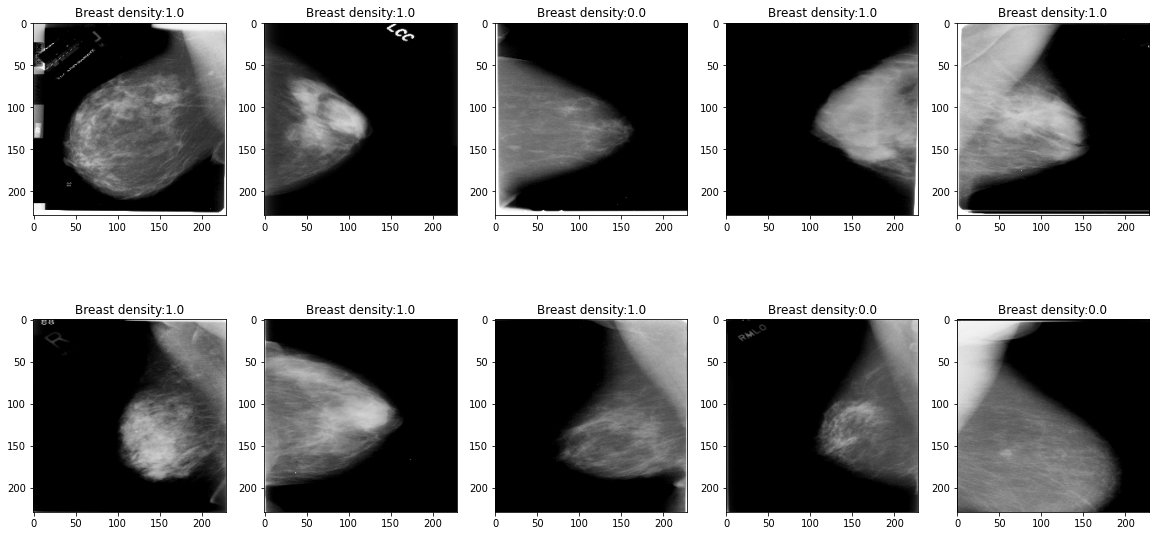

In [ ]:
# display 10 mammogram images 

# get the first batch from
test_iter =  iter(test_dataloader)
features, labels = next(test_iter)

# define figure with 2 rows and 5 columns 
fig = plt.figure(figsize=(20, 10))
rows = 2
columns = 5

num_img = 10
for idx in range(num_img):
  img = features[idx].squeeze()
  label = labels[idx].item()
  fig.add_subplot(rows, columns, idx + 1)
  # display image as grayscale 
  plt.imshow(img, cmap="gray")
  plt.title("Breast density:" + str(label))




In [149]:
model = modifiedResnet(test_dataloader=test_dataloader, train_dataloader=train_dataloader)
model.fit(num_epoch=50, verbose=False)

device:  cuda:0
Finished Training


In [150]:
y_pred, y_prob, y_true = model.predict()

device:  cuda:0
Finished with: 64 predictions.
Finished with: 100 predictions.
Accuracy: 69 %


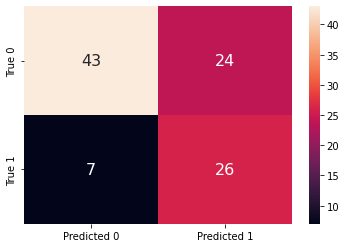

In [151]:
eval = EvaluateClassifier()
eval.confusion_matrix(y_pred, y_true) # confusion matrix

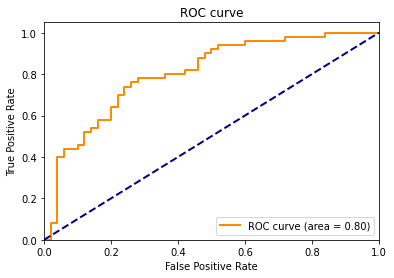

In [152]:
eval.roc_curve(y_prob, y_true) # roc curve 

(0.6101917904456041, 0.7711174701783785)


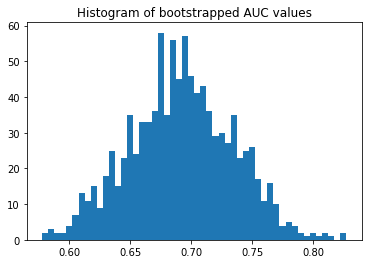

In [153]:
ci = eval.bootstrap_auc(y_pred, y_true) # histogram of bootstrapped auc
print(ci) # lower and upperbound of confidence interval

In [154]:
p_val = eval.DeLongTest(y_probs=y_prob, y_true=y_true) 
# perform DeLongTest to compare performance of model to random classifier
p_val # show p-value of DeLongTest, cut-off at 5%


2.7219022466268956e-05